# Predicting Inflammatory Bowel Disease (IBD) Using Patient Metagenomic Data

### Introduction

Inflammatory bowel disease (IBD) is an umbrella term to describe disorders characterized by inflammation of the digestive tract. IBD most commonly takes the form of two diseases: Crohn's disease and ulcerative colitis. Sometimes it is difficult for doctors for diagnose a patient's IBD either as Crohn's or ulcerative colitis, and in such cases, they are given a diagnosis of indeterminate colitis (IC). As many as 1.6 million americans are affected by IBD, most of which are diagnosed before the age of 35 [1]. Thus, there is a need to develop new methods for early detection of IBD and prevent further damage to patients. Previous studies have analyzed the metagenome of patients with and without IBD to understand if the composition of their microbiomes differ. Such data could help doctors determine if patients show early signs of IBD. Here we use microbial diversity data from 1357 patients' metagenomes to train a classifier and predict if a patient has IBD. 

## How Do We Measure Microbial Diversity?

Species diversity is the number of species that are represented in a community. In the case of the microbiome, it the number of different microbes that we find in individual(s). By understanding the taxonomic composition of metagenomes, we can analyze the diversity of different environments; in this case we can compare the gut microbiota of patients with and without IBD. Species diversity can be described by two measures:

- Alpha diversity: Measures the varaibility of species within a sample. Indeces that estimate alpha diversity consider the following:
    - richness: number of different species present in an environment
    - abundance: number of individuals of each species present in an environment. Abundance considers the evenness of a distribution of individuals among species in an environment.
- Beta diversity: Accounts for the differences in microbial composition between environments.

In the figure below (adapted from [2]), we can see a visualization of these two concepts. An environment is represented by a circle, which contains a unique combination of species, each with its alpha diversity, represented by the number of unique species in that environment. The beta diversity describes the number of species that differ between each environment.

In this analysis, we consider each sample take from a patient's gut as its own environment. We will use alpha and beta diversity metrics to descibes the diversity within and between samples and train a classifier on such data to predict if a patient has IBD.

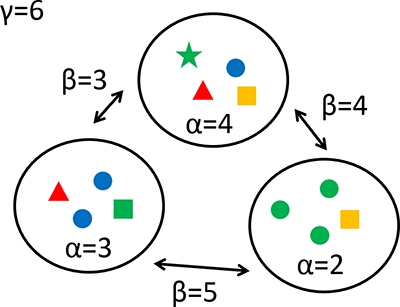

In [5]:
Image(filename="C:/Users/Saul Acevedo/Documents/crohns_disease_ml/diversity.gif")

## Import Libraries and Data

First thing is first: lets us import the necessary libraries we will be using. We will be using Scikitbio to calculate diversity metrics.

In [1]:
from biom import load_table
import pandas as pd
from Bio.Seq import Seq
from Bio.Blast import NCBIWWW
from skbio import DNA
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from collections import Counter
import numpy as np
import re
import colorcet as cc
from skbio.diversity import alpha_diversity
from skbio.diversity import get_beta_diversity_metrics
from skbio import DistanceMatrix
from skbio.diversity import beta_diversity
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
import datetime
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler 
from bioinfokit.visuz import cluster
from sklearn.decomposition import PCA
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from pycm import *
from imblearn.over_sampling import SMOTE 

sns.set(context='talk', style='ticks', palette='Set2')

We will be using metagnomic data from Gevers et al. (2014) [3]. Let us import the all.biom file using the  biom-format package, which trasnforms our data into a convenient pandas dataframe.

In [2]:
samples = load_table('data/study_1939_111821-192307/BIOM/128432/all.biom') 
sample_df = samples.to_dataframe().T
sample_df['sample_name'] = sample_df.index
sample_df

,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATGGGCAAGTCTGATGTGAAAACCCGGGGCTCAACCCCGGGACTGCATTGGAAACTGTTCATCTAGAGTGCTGGAGAGGTAAGTGGAATTCCTAG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGACTGGTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGTCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGG,TACGGAGGATTCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAATTTCGGGGCTCAACCCTGAACGTGCCTCTAATACTGTTGAGCTAGAGAGTAGTTGCGGTAGGCGGAATGTATGG,TACGTAGGATGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGGACTGCAAGTTGGATGTGAAATACCGTGGCTTAACCACGGAACTGCATCCAAAACTGTAGTTCTTGAGTGAAGTAGAGGCAAGCGGAATTCCGAG,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGCTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGG,CACGATTAACCCAAGTCAATAGAAGCCGGCGTAAAGAGTGTTTTAGATCACCCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCCAGTTGACACAAAATAGACTACGAAAGTGGCTTTAACATATCTGAACACACAAT,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCACGGCAAGCCAGATGTGAAAGCCCGGGGCTCAACCCCGGGACTGCATTTGGAACTGCTGAGCTAGAGTGTCGGAGAGGCAAGTGGAATTCCTAG,...,TACGTATGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGCAGCATGGCAAGTCAGAAGTGAAAGCCTGGGGCTCAACCCCGGAATTGCTTTTGAAACTGTCAGGCTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAG,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGGCAGAGGGAGGTAGAATTCCACG,TACGGAGGATTCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAATTTCGGGGCTCAACCCTGAACGTGCATCTAATACTGTTGAGCTAGAGAGTAGTTGCGGTAGGCGGAATGTATGG,TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGGACGCGTAGGCGGATTATCAAGTCTCTTGTGAAATCCTATGGCTTAACCATAGAACTGCTTGGGAAACTGATAATCTAGAGTGAGAGAGAGGCAGATGGAATTGGTGG,TACGTATGTCACAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGCGGTTATATAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCGTTGGAAACTGTGTAACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGT,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTCAGCAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTG,AACGTAGGGTGCTAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGTGGCAGTGCAAGTTGGATGTAAAATCTACGGGCTCAACCCGTATAAGCATTCAAAACTGTGCAGCTTGGGTGAAGTAGAGGTAGGTGGAATTTCCGGT,TACGTAGGGGGCAAGCGTTATCCGGATTTACCGGGTGTAAAGGGAGCGTAGACGGCAAGGCAAGTCTGATGTGAAAACCCAGGGCTTAACCCTGGGACTGCATTGGAAACTGTCTAGCTCGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGACGGCACTGCAAGTCTGAAGTGAAAGCCCGGGGATCAACCCCGGGACTGCTTTGGAAACTGTAGAGCTAGAGTGCTGAGAGGCAAGCGGAATTCCTAGT,sample_name
1939.MGH101748,207.0,180.0,131.0,128.0,80.0,70.0,61.0,59.0,56.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.MGH101748
1939.121953.b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.121953.b
1939.100198,1665.0,0.0,0.0,827.0,0.0,323.0,0.0,288.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.100198
1939.122039.a,0.0,479.0,53.0,42.0,0.0,532.0,0.0,77.0,0.0,194.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.122039.a
1939.MGH101763,0.0,255.0,43.0,645.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.MGH101763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939.SKBTI065,3425.0,1667.0,7.0,561.0,84.0,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.SKBTI065
1939.SKBTI066.a,348.0,12.0,1.0,0.0,118.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.SKBTI066.a
1939.SKBTI066.b,1766.0,54.0,17.0,0.0,359.0,3.0,0.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.SKBTI066.b
1939.SKBTI067,323.0,661.0,0.0,40.0,0.0,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

We will also import metadata from each patient sample. It contains information like their age, diagnosis, birthdate, etc. We only need to worry about the diagnosis column and the sample name.

In [3]:
metadata_df = pd.read_csv('data/1939_20180418-110402.txt', sep = '\t')
metadata_df

,sample_name,age,age_unit,altitude,anonymized_name,antibiotics,b_cat,biologics,biopsy_location,birthdate,...,qiita_study_id,race,sample_type,scientific_name,sex,smoking,steroids,taxon_id,title,type_sample
0,1939.100001,19.000000,years,0,100001,False,Missing: Restricted access,Missing: Restricted access,stool,Missing: Restricted access,...,1939,Missing: Not provided,stool,human gut metagenome,male,Never,false,408170,The Treatment-Naive Microbiome in New-Onset Cr...,stool
1,1939.100003,26.000000,years,0,100003,False,Missing: Restricted access,Missing: Restricted access,stool,Missing: Restricted access,...,1939,Missing: Not provided,stool,human gut metagenome,male,Current,true,408170,The Treatment-Naive Microbiome in New-Onset Cr...,stool
2,1939.100009,55.000000,years,0,100009,False,Missing: Restricted access,Missing: Restricted access,stool,Missing: Restricted access,...,1939,Missing: Not provided,stool,human gut metagenome,male,Never,false,408170,The Treatment-Naive Microbiome in New-Onset Cr...,stool
3,1939.100015,57.000000,years,0,100015,False,Missing: Restricted access,Missing: Restricted access,stool,Missing: Restricted access,...,1939,Missing: Not provided,stool,human gut metagenome,female,Current,false,408170,The Treatment-Naive Microbiome in New-Onset Cr...,stool
4,1939.100016,46.000000,years,0,100016,False,Missing: Restricted access,Missing: Restricted access,stool,Missing: Restricted access,...,1939,Missing: Not provided,stool,human gut metagenome,male,Never,true,408170,The Treatment-Naive Microbiome in New-Onset Cr...,stool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,1939.SKBTI092.b,7.583333,years,0,SKBTI092,False,B1,false,Terminal ileum,Missing: Restricted access,...,1939,other,biopsy,human gut metagenome,male,Missing: Not provided,false,408170,The Treatment-Naive Microbiome in New-Onset Cr...,biopsy
1355,1939.SKBTI093,12.750000,years,0,SKBTI093,False,B1,false,Terminal ileum,Missing: Restricted access,...,1939,other,biopsy,human gut metagenome,male,Missing: Not provided,false,408170,The Treatment-Naive Microbiome in New-Onset Cr...,biopsy
1356,1939.SKBTI094,8.166667,years,0,SKBTI094,False,B1,false,Terminal ileum,Missing: Restricted access,...,1939,caucasian,biopsy,human gut metagenome,male,Missing: Not provided,false,408170,The Treatment-Naive Microbiome in New-Onset Cr...,biopsy
1357,1939.SKBTI095,14.083333,years,0,SKBTI095,False,B1,false,Terminal ileum,Missing: Restricted access,...,1939,other,biopsy,human gut metagenome,female,Missing: Not provided,false,408170,The Treatment-Naive Microbiome in New-Onset Cr...,biopsy


Now let us merge the biom and metadata dataframes into a single dataframe that describes the microbiome of each patient.

In [8]:
sample_df = pd.merge(sample_df, metadata_df[['diagnosis', 'sample_name']], on='sample_name')
sample_df

,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATGGGCAAGTCTGATGTGAAAACCCGGGGCTCAACCCCGGGACTGCATTGGAAACTGTTCATCTAGAGTGCTGGAGAGGTAAGTGGAATTCCTAG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGACTGGTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGTCAGTCTTGAGTACAGTAGAGGTGGGCGGAATTCGTGG,TACGGAGGATTCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAATTTCGGGGCTCAACCCTGAACGTGCCTCTAATACTGTTGAGCTAGAGAGTAGTTGCGGTAGGCGGAATGTATGG,TACGTAGGATGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGGACTGCAAGTTGGATGTGAAATACCGTGGCTTAACCACGGAACTGCATCCAAAACTGTAGTTCTTGAGTGAAGTAGAGGCAAGCGGAATTCCGAG,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTGCTTTCAAAACTGCTGGCCTTGAGTAGTGCAGAGGTAGGTGGAATTCCCGG,CACGATTAACCCAAGTCAATAGAAGCCGGCGTAAAGAGTGTTTTAGATCACCCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCCAGTTGACACAAAATAGACTACGAAAGTGGCTTTAACATATCTGAACACACAAT,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCACGGCAAGCCAGATGTGAAAGCCCGGGGCTCAACCCCGGGACTGCATTTGGAACTGCTGAGCTAGAGTGTCGGAGAGGCAAGTGGAATTCCTAG,...,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGGCAGAGGGAGGTAGAATTCCACG,TACGGAGGATTCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAATTTCGGGGCTCAACCCTGAACGTGCATCTAATACTGTTGAGCTAGAGAGTAGTTGCGGTAGGCGGAATGTATGG,TACGGAGGGTGCAAGCGTTACTCGGAATCACTGGGCGTAAAGGACGCGTAGGCGGATTATCAAGTCTCTTGTGAAATCCTATGGCTTAACCATAGAACTGCTTGGGAAACTGATAATCTAGAGTGAGAGAGAGGCAGATGGAATTGGTGG,TACGTATGTCACAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGCGGTTATATAAGTCTGATGTGAAAATGCAGGGCTCAACTCTGTATTGCGTTGGAAACTGTGTAACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGT,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTCAGCAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTG,AACGTAGGGTGCTAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGTGGCAGTGCAAGTTGGATGTAAAATCTACGGGCTCAACCCGTATAAGCATTCAAAACTGTGCAGCTTGGGTGAAGTAGAGGTAGGTGGAATTTCCGGT,TACGTAGGGGGCAAGCGTTATCCGGATTTACCGGGTGTAAAGGGAGCGTAGACGGCAAGGCAAGTCTGATGTGAAAACCCAGGGCTTAACCCTGGGACTGCATTGGAAACTGTCTAGCTCGAGTGCCGGAGAGGTAAGCGGAATTCCTAG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGACGGCACTGCAAGTCTGAAGTGAAAGCCCGGGGATCAACCCCGGGACTGCTTTGGAAACTGTAGAGCTAGAGTGCTGAGAGGCAAGCGGAATTCCTAGT,sample_name,diagnosis
0,207.0,180.0,131.0,128.0,80.0,70.0,61.0,59.0,56.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.MGH101748,CD
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.121953.b,UC
2,1665.0,0.0,0.0,827.0,0.0,323.0,0.0,288.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.100198,CD
3,0.0,479.0,53.0,42.0,0.0,532.0,0.0,77.0,0.0,194.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.122039.a,CD
4,0.0,255.0,43.0,645.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.MGH101763,CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,3425.0,1667.0,7.0,561.0,84.0,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.SKBTI065,no
1353,348.0,12.0,1.0,0.0,118.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.SKBTI066.a,CD
1354,1766.0,54.0,17.0,0.0,359.0,3.0,0.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.SKBTI066.b,CD
1355,323.0,661.0,0.0,40.0,0.0,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.SKBTI067,no


Each row is a different patient and each column a different sequence of an operational taxonomic unit, or OTU. OTUs represent clusters of similar sequence variants of the 16s rRNA. 16s rRNA is commanly used to differentiate between OTUs due to their highly conserved and hypervariable regions [4]. 

We can observe the different classes of diagnosis in the patient metadata dataframe by using a barplot. For simplicity, we will focus on training a binary classifier. Therefore, we can combine the different types of IBD into one class and consider the rest of the patients as healthy. We can see that our classes are imbalanced. Later, we will use techniques to handle our imbalanced dataset. 

C:\Users\Saul Acevedo\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


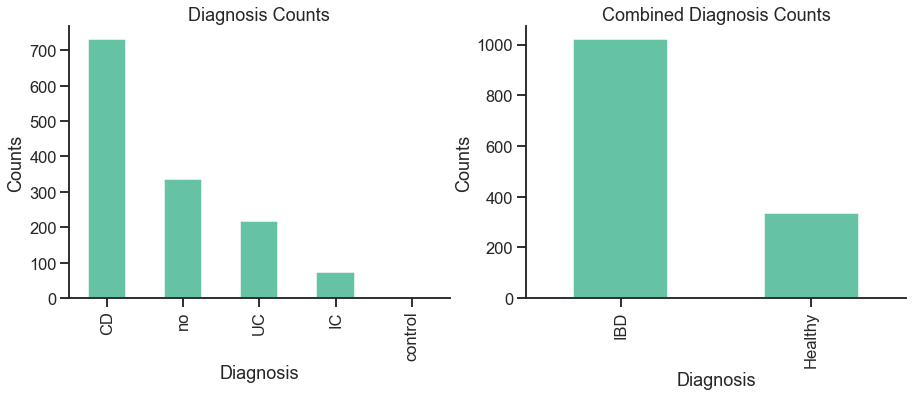

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sample_df['diagnosis'].value_counts().plot.bar(ax=ax[0])
ax[0].set_xlabel('Diagnosis')
ax[0].set_ylabel('Counts')
ax[0].set_title('Diagnosis Counts') 
sns.despine()

sample_df['diagnosis'] = sample_df['diagnosis'].replace(['CD', 'UC', 'IC'], 'IBD')
sample_df['diagnosis'] = sample_df['diagnosis'].replace(['no', 'control'], 'Healthy')

sample_df['diagnosis'].value_counts().plot.bar(ax=ax[1])
ax[1].set_xlabel('Diagnosis')
ax[1].set_ylabel('Counts')
ax[1].set_title('Combined Diagnosis Counts') 
sns.despine()


## Identifying OTUs

Here we will try to identify the genus each of our OTUs belongs to in order to understand the differences between microbiota of patients with and without IBD. To do this, we will use BLAST, a commonly used tool in bioinformatics to compare the similarities of a  sequence against a database of sequences. We can use this knowledge to which species a particular gene belongs to. First we will add the OTU sequences into their own dataframe:

In [10]:
seqs = sample_df.columns.to_list()[:-2]

indeces = range(0, len(seqs))
data = {'sequence':seqs}
df_seqs = pd.DataFrame(data=data)

df_seqs.head()

,sequence
0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...
1,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...
2,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...
3,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...
4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...


We will also label each column in our sample_df dataframe with an index instead of a sequence for easier identification.

In [11]:
old_col_names = sample_df.columns[indeces] 
sample_df.rename(columns=dict(zip(old_col_names, indeces)), inplace=True)
sample_df.head()

,0,1,2,3,4,5,6,7,8,9,...,38238,38239,38240,38241,38242,38243,38244,38245,sample_name,diagnosis
0,207.0,180.0,131.0,128.0,80.0,70.0,61.0,59.0,56.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.MGH101748,IBD
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.121953.b,IBD
2,1665.0,0.0,0.0,827.0,0.0,323.0,0.0,288.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.100198,IBD
3,0.0,479.0,53.0,42.0,0.0,532.0,0.0,77.0,0.0,194.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.122039.a,IBD
4,0.0,255.0,43.0,645.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1939.MGH101763,IBD


Let us write a fasta file that contains sequences from our df_seqs dataframe. Fasta is a format commonly used in bioinformatics to prepare sequence data fro analysis.

In [12]:
output_file = open('IBD.fasta', 'w')

for index, seq in enumerate(seqs):
    output_file.write(">OTU_{0}\n".format(index))
    output_file.write(seq + '\n')
    
output_file.close()

From the command line, we run BLAST. We will set the output format to xml and only want the top 5 scoring sequences. NCBI has a 16s rRNA database that we can use to compare our sequences against.

In [ ]:
!blastn -query IBD.fasta -out crohns_otu.xml -db 16S_ribosomal_RNA -outfmt 5 -max_target_seqs 5

We will then parse the output and the consider the most commonly ocurring genus in our five sequences as the identity of our OTUs. Each sequence in our df_seqs dataframe now has a genus.

In [13]:
tree = ET.parse('crohns_otu.xml')
root = tree.getroot()
seq_genera = []
seq_sp = []

for iteration in root.findall('./BlastOutput_iterations/Iteration'):
    genus_list = []
    for hit in iteration[4]:
        genus_list.append(hit[2].text.split(' ')[0])
    if len(genus_list) != len(set(genus_list)):
        seq_sp.append(hit[2].text.split(' ')[0] + ' ' + hit[2].text.split(' ')[1])
        seq_genera.append(re.sub(r"[\[\]]", "", max(genus_list, key=genus_list.count)))
    else:
        if len(genus_list) > 0:
            seq_sp.append(hit[2].text.split(' ')[0] + ' ' + hit[2].text.split(' ')[1])
            seq_genera.append(re.sub(r"[\[\]]", "", genus_list[0]))
        else:
            seq_sp.append(hit[2].text.split(' ')[0] + ' ' + hit[2].text.split(' ')[1])
            seq_genera.append('Other')

In [15]:
df_seqs['genus'] = seq_genera
df_seqs.head()

,sequence,genus
0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteroides
1,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Faecalibacterium
2,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Ruminococcus
3,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Faecalibacterium
4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteroides


We then calculate the counts of each genus appearing in both patients that are healthy or have IBD:

In [16]:
ibd_sample_df = sample_df[sample_df['diagnosis'] == 'IBD']
healthy_sample_df = sample_df[sample_df['diagnosis'] == 'Healthy']

seq_counts_ibd = []
seq_counts_healthy = []

for row in df_seqs.iterrows():
    seq_counts_ibd.append(ibd_sample_df[row[0]].sum())
    seq_counts_healthy.append(healthy_sample_df[row[0]].sum())

In [17]:
df_seqs['ibd_counts'] = seq_counts_ibd
df_seqs['healthy_counts'] = seq_counts_healthy
df_seqs.head()

,sequence,genus,ibd_counts,healthy_counts
0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteroides,2384315.0,1329467.0
1,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Faecalibacterium,937786.0,633721.0
2,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Ruminococcus,76976.0,35958.0
3,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Faecalibacterium,189839.0,81173.0
4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteroides,1083762.0,484769.0


We then seperate the genus counts for each class (Healthy, IBD) into their own dataframe. This makes it easier to calculate the percentage of each genus found in each class:

In [18]:
df_seqs_counts_ibd = df_seqs.groupby(['genus']).sum().drop(columns=['healthy_counts']).sort_values(by='ibd_counts', ascending=False)
df_seqs_counts_healthy = df_seqs.groupby(['genus']).sum().drop(columns=['ibd_counts']).sort_values(by='healthy_counts', ascending=False)

In [19]:
df_seqs_counts_ibd['percent_ibd'] = df_seqs_counts_ibd['ibd_counts']/df_seqs_counts_ibd['ibd_counts'].sum()
df_seqs_counts_healthy['percent_healthy'] = df_seqs_counts_healthy['healthy_counts']/df_seqs_counts_healthy['healthy_counts'].sum()

In [20]:
df_seqs_counts_ibd.head(20)

,ibd_counts,percent_ibd
genus,,
Bacteroides,6029820.0,0.282727
Faecalibacterium,2013621.0,0.094415
Escherichia,1381103.0,0.064757
Clostridium,1308380.0,0.061348
Ruminococcus,1007501.0,0.047240
Blautia,825488.0,0.038706
Roseburia,616214.0,0.028893
Haemophilus,575135.0,0.026967
Parabacteroides,430248.0,0.020174


In [21]:
df_seqs_counts_healthy.head(20)

,healthy_counts,percent_healthy
genus,,
Bacteroides,2980759.0,0.371534
Faecalibacterium,878186.0,0.109461
Clostridium,489145.0,0.060969
Ruminococcus,359910.0,0.044861
Escherichia,350011.0,0.043627
Roseburia,295315.0,0.036809
Parabacteroides,275302.0,0.034315
Prevotella,201214.0,0.025080
Other,183276.0,0.022844


Many of these species are very rare, and therfore occur only in a few samples. For simplicity, we only want to consider the top 20 most abundant genera found in both classes. The rest we label as 'Other'.

In [22]:
old_col_names = df_seqs_counts_healthy.index[20:]
df_seqs_counts_healthy.rename(index=dict(zip(old_col_names, ['Other']*len(old_col_names))), inplace=True)
df_seqs_counts_healthy = df_seqs_counts_healthy.groupby(level=0).sum()

old_col_names = df_seqs_counts_ibd.index[20:]
df_seqs_counts_ibd.rename(index=dict(zip(old_col_names, ['Other']*len(old_col_names))), inplace=True)
df_seqs_counts_ibd = df_seqs_counts_ibd.groupby(level=0).sum()

In [23]:
df_seqs_counts_healthy

,healthy_counts,percent_healthy
genus,,
Akkermansia,84560.0,0.010540
Alistipes,132162.0,0.016473
Anaerostipes,60613.0,0.007555
Bacteroides,2980759.0,0.371534
Blautia,136563.0,0.017022
Clostridium,489145.0,0.060969
Dialister,59856.0,0.007461
Escherichia,350011.0,0.043627
Faecalibacterium,878186.0,0.109461


In [24]:
df_seqs_counts_ibd

,ibd_counts,percent_ibd
genus,,
Akkermansia,231093.0,0.010836
Alistipes,288282.0,0.013517
Bacteroides,6029820.0,0.282727
Bifidobacterium,284431.0,0.013336
Blautia,825488.0,0.038706
Clostridium,1308380.0,0.061348
Dialister,409597.0,0.019205
Escherichia,1381103.0,0.064757
Faecalibacterium,2013621.0,0.094415


We finally merge both of the dataframes into a single dataframe with the percent abundance of genera in both healthy and IBD patients. We then visualize the difference in abundances among these two classes using a stacked bar plot.

In [25]:
genus_seq_counts = pd.merge(left=df_seqs_counts_healthy, left_index=True,
                  right=df_seqs_counts_ibd, right_index=True,
                  how='outer').fillna(0)

In [26]:
genus_seq_counts

,healthy_counts,percent_healthy,ibd_counts,percent_ibd
genus,,,,
Akkermansia,84560.0,0.010540,231093.0,0.010836
Alistipes,132162.0,0.016473,288282.0,0.013517
Anaerostipes,60613.0,0.007555,0.0,0.000000
Bacteroides,2980759.0,0.371534,6029820.0,0.282727
Bifidobacterium,0.0,0.000000,284431.0,0.013336
Blautia,136563.0,0.017022,825488.0,0.038706
Clostridium,489145.0,0.060969,1308380.0,0.061348
Dialister,59856.0,0.007461,409597.0,0.019205
Escherichia,350011.0,0.043627,1381103.0,0.064757


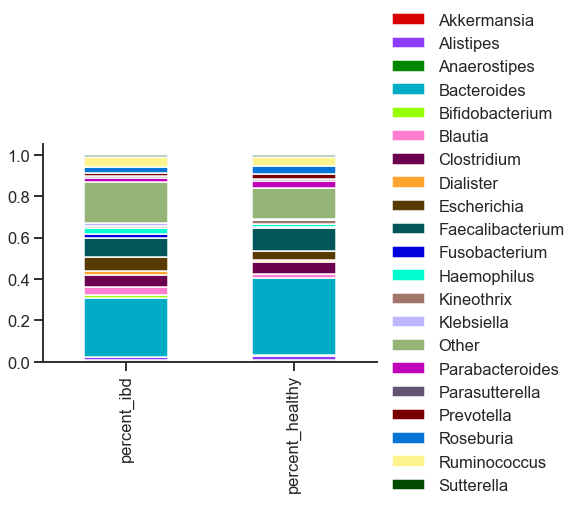

In [27]:
genus_seq_counts[['percent_ibd', 'percent_healthy']].T.plot.bar(stacked=True, color=sns.color_palette(cc.glasbey, n_colors=21))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
sns.despine()

We see what genera make up the microbiota of each patient class. We can observe that patients with IBD have less abundant Bacteroides anf Faecalibacterium that healthy patients. IBD patients have a higher abundance of bacteria classified as 'Other', which could indicate that the gut of IBD patients could be more hospitable to unwelcome guests, like malicious bacteria.


Let us use this abundance data as features for our machine learning models. First, we will create a new dataframe that contains the features for each of our patients:

In [28]:
data = {'sample_name': sample_df['sample_name'], 'diagnosis':sample_df['diagnosis']}
sample_features_df = pd.DataFrame(data=data)

In [29]:
sample_features_df

,sample_name,diagnosis
0,1939.MGH101748,IBD
1,1939.121953.b,IBD
2,1939.100198,IBD
3,1939.122039.a,IBD
4,1939.MGH101763,IBD
...,...,...
1352,1939.SKBTI065,Healthy
1353,1939.SKBTI066.a,IBD
1354,1939.SKBTI066.b,IBD
1355,1939.SKBTI067,Healthy


Then add the percentages of the top 20 genera into our dataframe:

In [159]:
sample_df_modified = sample_df.copy()
sample_df_modified.rename(columns=dict(zip(sample_df_modified.columns, df_seqs['genus'])), inplace=True)
sample_df_modified = sample_df_modified.groupby(level=0, axis=1).sum()
sample_df_modified = sample_df_modified.reindex(sample_df_modified.iloc[:, :-3].sum().sort_values(ascending=False).index, axis=1)
sample_df_modified['diagnosis'] = sample_df['diagnosis']
sample_df_modified.rename(columns=dict(zip(sample_df_modified.columns[20:], len(sample_df_modified.columns[20:])* ['Other'])), inplace=True)
sample_df_modified = sample_df_modified.groupby(level=0, axis=1).sum()
sample_df_modified[sample_df_modified.columns] = sample_df_modified[sample_df_modified.columns].div(sample_df_modified[sample_df_modified.columns].sum(axis=1), axis=0)
sample_features_df[sample_df_modified.columns] = sample_df_modified[sample_df_modified.columns]

## Estimating Alpha Diversity

Next, we estimate alpha diversity metrics that take into account species richness, evenness, and abundance. Each metric will be calculated for each individual patient sample. We consider the following metrics:

- Number of Observed OTUs
- Singletons: Number of OTUs that occur once in a sample
- Doubletons: Number of OTUs that occur twice in a sample
- Chao 1 [5]: Estimates species richness by considering rare OTUs, such as singletons and doubletons. The idea behind this estimator is that if rare species are still being discovered, there are still more new species to be found. The larger the metric, the greater the species richness.
- ACE [6]: Richness metric that considers the number of rare species to estimate how many more undiscovered species may exist. The larger the metric, the greater the species richness.
- Simpson Index [7]: Considers the degree of dominance of a particular OTU; if a few species make up lots of the microbiome in an environment, diversity is low. 
- Pielou Evenness [8]: An evenness metric that estimates how close in numbers each OTU in an environment is. It is constrained between 0 and 1, where the closer to 1 the metric is the more even the community in the sample is.
- Simpson Evenness: Similar to  Pielou evenness but calculated using the simson index; bounded between 0 and 1, with 1 being complete evenness of the community.
- Shannon diversity [9]: Otherwise known as Shannon's entropy in information theory, it considers species richness and abundance. It increases with the number of OTUs and their abundance. The higher the value, the higher the alpha diversity of the sample.
- Berger-Parker Index [10]: Dominance index that is equal to the fraction of the most abundant OTU in the sample.

We find that most metrics are higher in healthy individuals. Evenness seems to be higher in individuals with IBD. We also observe that for most of these metrics, the IBD class has more outliers. Because a significant number of samples are outliers, it might be best to leave them in our dataset. Let us add all these metrics as features for each of our samples.

In [31]:
species_richness = alpha_diversity('observed_otus', sample_df.iloc[:, :-2], sample_df['sample_name'])
singles = alpha_diversity('singles', sample_df.iloc[:, :-2], sample_df['sample_name'])
doubles = alpha_diversity('doubles', sample_df.iloc[:, :-2], sample_df['sample_name'])
sample_features_df['num_observed_otus'] = list(species_richness)
sample_features_df['singles'] = list(singles)
sample_features_df['doubles'] = list(doubles)

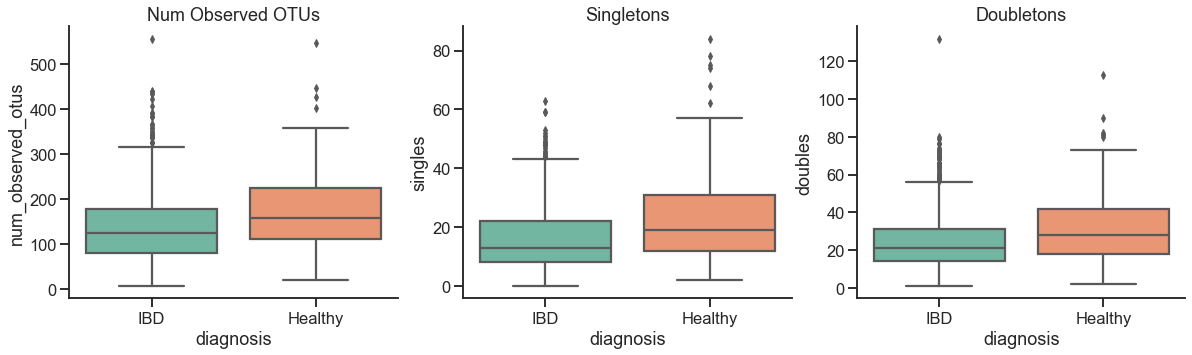

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.boxplot(x='diagnosis', y='num_observed_otus', data=sample_features_df, ax=ax[0])
ax[0].set_title('Num Observed OTUs')
sns.boxplot(x='diagnosis', y='singles', data=sample_features_df, ax=ax[1])
ax[1].set_title('Singletons')
sns.boxplot(x='diagnosis', y='doubles', data=sample_features_df, ax=ax[2])
ax[2].set_title('Doubletons')
sns.despine()

In [33]:
chao1 = alpha_diversity('chao1', sample_df.iloc[:, :-2], sample_df['sample_name'])
ace = alpha_diversity('ace', sample_df.iloc[:, :-2].astype('int'), sample_df['sample_name'])
sample_features_df['chao1'] = list(chao1)
sample_features_df['ace'] = list(ace)

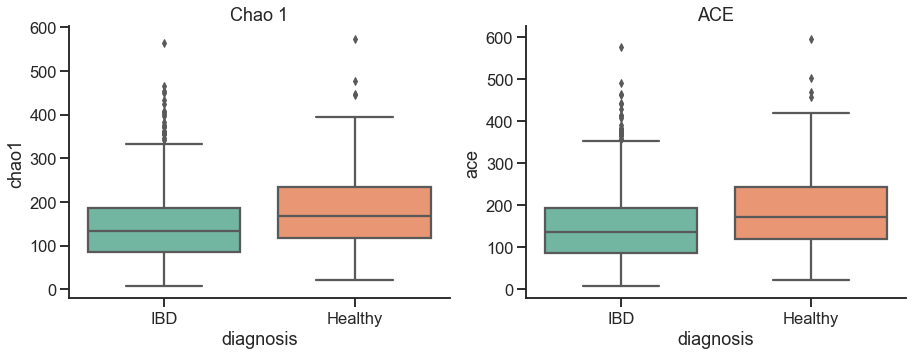

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(x='diagnosis', y='chao1', data=sample_features_df, ax=ax[0])
ax[0].set_title('Chao 1')
sns.boxplot(x='diagnosis', y='ace', data=sample_features_df, ax=ax[1])
ax[1].set_title('ACE')
sns.despine()

In [35]:
pielou_e = alpha_diversity('pielou_e', sample_df.iloc[:, :-2], sample_df['sample_name'])
simpson_e = alpha_diversity('simpson_e', sample_df.iloc[:, :-2].astype('int'), sample_df['sample_name'])
sample_features_df['pielou_e'] = list(pielou_e)
sample_features_df['simpson_e'] = list(simpson_e)

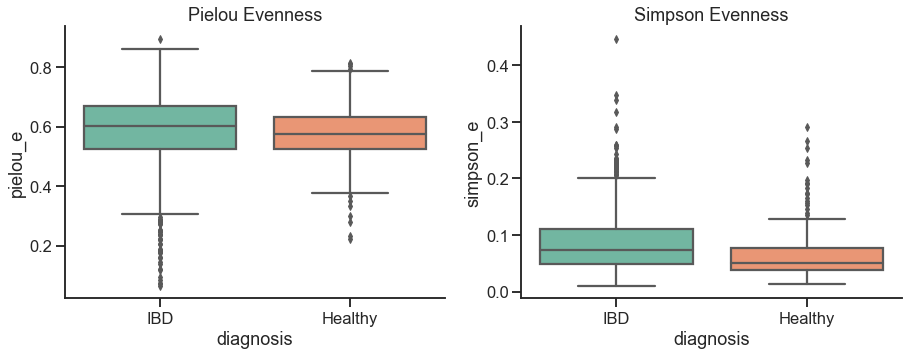

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.boxplot(x='diagnosis', y='pielou_e', data=sample_features_df, ax=ax[0])
ax[0].set_title('Pielou Evenness')
sns.boxplot(x='diagnosis', y='simpson_e', data=sample_features_df, ax=ax[1])
ax[1].set_title('Simpson Evenness')
sns.despine()

In [39]:
shannon_diversity = alpha_diversity('shannon', sample_df.iloc[:, :-2], sample_df['sample_name'])
simpson = alpha_diversity('simpson', sample_df.iloc[:, :-2], sample_df['sample_name'])
berger_parker = alpha_diversity('berger_parker_d', sample_df.iloc[:, :-2], sample_df['sample_name'])
sample_features_df['shannon'] = list(shannon_diversity)
sample_features_df['simpson'] = list(simpson)
sample_features_df['berger_parker'] = list(berger_parker)

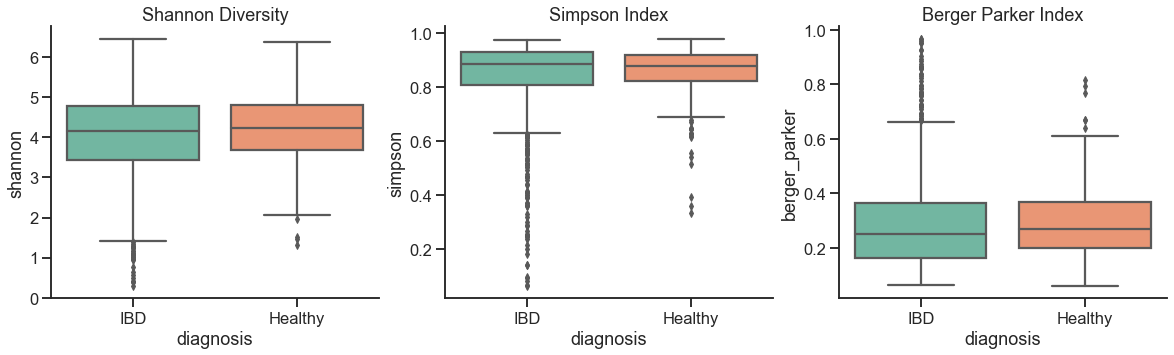

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.boxplot(x='diagnosis', y='shannon', data=sample_features_df, ax=ax[0])
ax[0].set_title('Shannon Diversity')
sns.boxplot(x='diagnosis', y='simpson', data=sample_features_df, ax=ax[1])
ax[1].set_title('Simpson Index')
sns.boxplot(x='diagnosis', y='berger_parker', data=sample_features_df, ax=ax[2])
ax[2].set_title('Berger Parker Index')
sns.despine()

## Estimating Beta Diversity

We next look at the beta diversity between our samples. This can be best observed by calculating a NxN distance matrix, where N is the total number of patient samples.  Each entry compares similarity between two samples. The metrics we use are:

- Jaccard Distance [11]: Calculates the percentage of OTUs present in both samples.
- Bray-Curtis Dissimilarity [12]: Considers the differences in microbial abundances between two samples and is bounded between 0 and 1, where 1 indicates both samples have completely different species abundances.

In [49]:
bc_dm = beta_diversity("braycurtis", sample_df.iloc[:, :-2].to_numpy(), sample_df.index)
jd_dm = beta_diversity("jaccard", sample_df.iloc[:, :-2].to_numpy(), sample_df.index)
data={'diagnosis':sample_df['diagnosis'], 'sample':sample_df['sample_name']}
sample_md = pd.DataFrame(data=data,
   index=sample_df.index)

C:\Users\Saul Acevedo\anaconda3\lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.3066059514965886 and the largest is 53.08967058198561.
  RuntimeWarning
C:\Users\Saul Acevedo\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\Saul Acevedo\anaconda3\lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenva

We can better visualize beta diversity using clustering techniques. A commonly used technique in metagenomics to do this is Principal Coordinates Analysis (PCoA), which is similar to the commonly used Principal Components Analysis (PCA). However instead of considering variance, PCoA considers distance. We can observe some clustering between healthy and IBD patients. Healthy patients are more concentrated to the right of PC1 while those with IBD tend more to the left. Calculating Jaccard and Bray-Curtis indeces, we find that patients with IBD have a slightly higher average bray-curtis dissimilarity and healthy individuals have a slightly higher average jaccard index.

In [ ]:
bc_pc = pcoa(bc_dm, number_of_dimensions=2)
jd_pc = pcoa(jd_dm, number_of_dimensions=2)

In [50]:
bc_pc.samples['diagnosis'] = sample_df['diagnosis']
jd_pc.samples['diagnosis'] = sample_df['diagnosis']

In [71]:
healthy_indeces = sample_df[sample_df['diagnosis'] == 'Healthy'].index.to_numpy()
healthy_beta_bc = []
healthy_beta_jd = []

for index in healthy_indeces:
    print(index)
    healthy_beta_bc.append(np.mean(bc_dm.data[index][sample_df[sample_df['diagnosis'] == 'IBD'].index]))
    healthy_beta_jd.append(np.mean(jd_dm.data[index][sample_df[sample_df['diagnosis'] == 'IBD'].index]))

9
199
201
252
267
271
286
293
295
296
302
311
326
338
340
349
354
363
365
368
375
378
379
384
386
401
412
417
428
431
438
442
443
446
447
449
451
454
458
459
461
463
464
466
470
472
475
480
483
495
501
511
516
521
523
525
534
536
540
542
547
550
556
565
578
581
587
588
592
593
596
600
603
605
608
609
615
618
619
623
628
630
631
632
635
638
639
640
641
643
645
646
651
653
654
655
656
657
658
662
666
667
670
671
673
676
678
679
680
689
693
695
699
705
706
710
716
717
725
726
728
730
733
738
742
744
748
749
750
753
756
760
764
775
777
781
782
788
791
792
815
816
818
820
821
830
836
838
843
845
847
849
851
869
870
874
882
899
900
903
908
912
913
915
916
920
921
922
925
932
933
935
939
940
943
948
951
953
954
956
959
963
974
977
981
982
985
991
992
994
995
1000
1001
1002
1004
1005
1006
1007
1009
1012
1015
1016
1019
1021
1024
1026
1029
1031
1033
1035
1038
1039
1044
1045
1046
1047
1051
1052
1057
1060
1061
1062
1064
1066
1067
1073
1076
1077
1081
1082
1083
1084
1086
1088
1093
1097
1098
1101
110

In [72]:
ibd_indeces = sample_df[sample_df['diagnosis'] == 'IBD'].index.to_numpy()
ibd_beta_bc = []
ibd_beta_jd = []

for index in ibd_indeces:
    print(index)
    ibd_beta_bc.append(np.mean(bc_dm.data[index][sample_df[sample_df['diagnosis'] == 'Healthy'].index]))
    ibd_beta_jd.append(np.mean(jd_dm.data[index][sample_df[sample_df['diagnosis'] == 'Healthy'].index]))

0
1
2
3
4
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
200
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
253
254
255
256
257
258
259
260
261
262
263
264
265
266
268
269
270
272
273
274
275
276
277
278
279
280
281
282


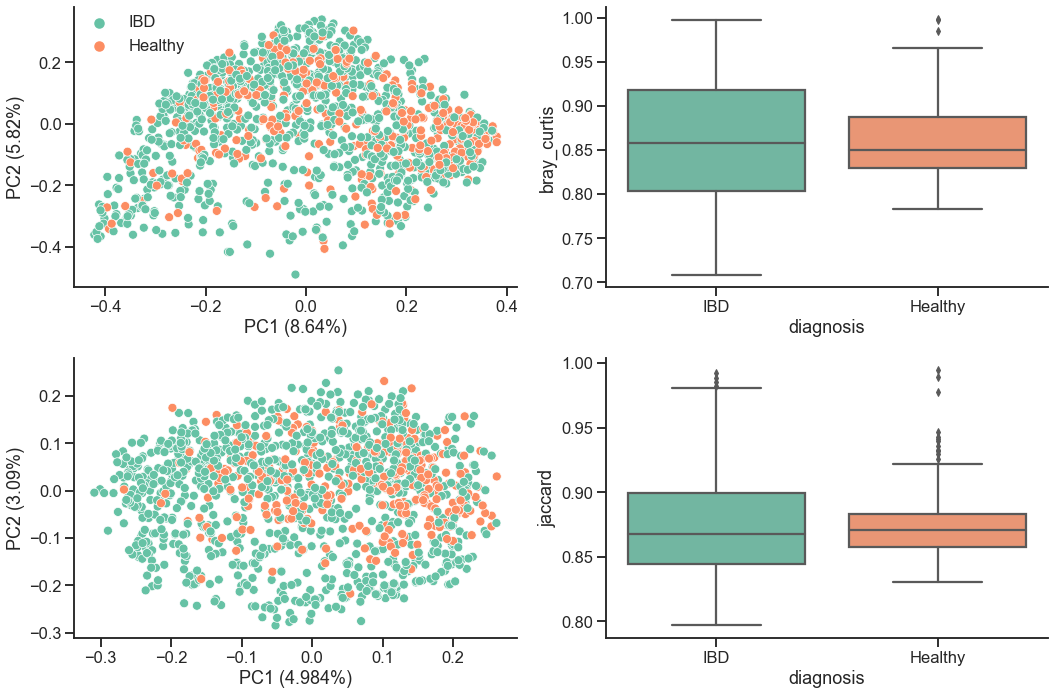

In [85]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.scatterplot(data=bc_pc.samples, x="PC1", y="PC2", hue="diagnosis", ax=ax[0, 0])
ax[0, 0].legend(frameon=False, loc='upper left', borderpad=0.001)
ax[0, 0].set_xlabel('PC1 (8.64%)')
ax[0, 0].set_ylabel('PC2 (5.82%)')
sns.boxplot(x='diagnosis', y='bray_curtis', data=sample_features_df, ax=ax[0, 1])
sns.scatterplot(data=jd_pc.samples, x="PC1", y="PC2", hue="diagnosis", ax=ax[1, 0], legend=False)
ax[1, 0].set_xlabel('PC1 (4.984%)')
ax[1, 0].set_ylabel('PC2 (3.09%)')
sns.boxplot(x='diagnosis', y='jaccard', data=sample_features_df, ax=ax[1, 1])
sns.despine()

fig.tight_layout()

To reduce dimensionality of the beta diversity distance matrices, we will consider the average distance between a single sample of one class and all the samples of the other. For example, if we consider a healthy individual, we would calculate the average distance between them and all patients who have IBD. Let us add these newly engineered features to our sample_features_df dataframe. We convert the dataframe to a csv file for later analysis.

In [87]:
sample_features_df.loc[ibd_indeces, 'bray_curtis'] = ibd_beta_bc
sample_features_df.loc[healthy_indeces, 'bray_curtis'] = healthy_beta_bc

sample_features_df.loc[ibd_indeces, 'jaccard'] = ibd_beta_jd
sample_features_df.loc[healthy_indeces, 'jaccard'] = healthy_beta_jd

In [88]:
sample_features_df

,sample_name,diagnosis,num_observed_otus,singles,doubles,chao1,ace,pielou_e,simpson_e,shannon,simpson,berger_parker,bray_curtis,jaccard
0,1939.MGH101748,IBD,100,7,20,101.000000,103.407037,0.803425,0.243813,5.337837,0.958985,0.105236,0.894148,0.847760
1,1939.121953.b,IBD,36,6,4,39.000000,43.432352,0.709342,0.227130,3.667246,0.877701,0.266345,0.975565,0.970810
2,1939.100198,IBD,100,11,10,105.000000,106.639607,0.682828,0.149624,4.536611,0.933166,0.133746,0.833211,0.899382
3,1939.122039.a,IBD,310,37,76,318.649351,334.038415,0.725346,0.104879,6.003051,0.969243,0.075836,0.860483,0.873635
4,1939.MGH101763,IBD,72,3,11,72.250000,73.783389,0.718427,0.185250,4.432639,0.925026,0.163466,0.875465,0.873513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,1939.SKBTI065,Healthy,155,13,16,159.588235,161.842523,0.626058,0.058536,4.555273,0.889785,0.277283,0.827817,0.868854
1353,1939.SKBTI066.a,IBD,71,8,21,72.272727,75.069992,0.483674,0.054587,2.974470,0.741979,0.467171,0.891124,0.876249
1354,1939.SKBTI066.b,IBD,118,13,13,123.571429,124.485486,0.456217,0.039810,3.139981,0.787123,0.395638,0.830074,0.861503
1355,1939.SKBTI067,Healthy,213,22,38,218.923077,222.523159,0.513741,0.034583,3.973637,0.864243,0.305896,0.896049,0.925456


In [89]:
sample_features_df.to_csv('sample_features.csv')

In [158]:
sample_features_df = pd.read_csv('sample_features.csv')

## Model Training and Evaluation

Now let us seperate our data into training and testing dataset:

In [160]:
X = sample_features_df.drop(columns=['diagnosis', 'sample_name', 'Unnamed: 0'])
y = sample_features_df['diagnosis']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Since our features have different ranges, it will be best to scale them. We will use Scikitlearn's MinMaxScaler to do this, since our most of our data is not normally distributed. NOTE: MinMaxScaler is sensitive to outliers. We do have a large number of outliers in our dataset and it may have some effect on our model training.

In [162]:
scaler = MinMaxScaler()
lb = preprocessing.LabelBinarizer()
X_train_scaled = scaler.fit_transform(X_train)
y_train_binary = lb.fit_transform(y_train)

X_test_scaled = scaler.fit_transform(X_test)
y_test_binary = lb.fit_transform(y_test)

Lastly, we must remember that we have an imbalanced dataset. There are many techniques we can make use of to take care of this, including undersampling and oversampling. Since we have such limited data, we will decide to use the oversampling technique SMOTE, or Synthetic Minority Oversampling TEchnique. SMOTE works by using the K-Nearest neighbor algorithm to cluster the majority and minority classes. Two neighbors in the minority cluster are randomly selected and form a line in feature space, where synthetic samples are created at a randomly selected point between them.

In [163]:
sm = SMOTE(random_state=42)
X_train_scaled, y_train_binary = sm.fit_resample(X_train_scaled, y_train_binary)

Now let us test different classification models. We will look at logistic regression, KNN, Naive Bayes, SVC, and the Random Forest. To assess these models, we will calculate the following metrics using Cross-Validation: Accuracy, AUC, and the F1-Score.

In [233]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    
    fpr, tpr, _ = metrics.roc_curve(y_train, train_pred)
    roc_auc = metrics.auc(fpr, tpr)
    f1_score = metrics.f1_score(y_train, train_pred)

    
    return acc_cv, roc_auc, f1_score

In [234]:
# Logistic Regression
start_time = time.time()
acc_cv_log, roc_auc_log, f1_score_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train_scaled, 
                                                               y_train_binary.ravel(), 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("AUC: %s" % roc_auc_log)
print("F1 Score: %s" % f1_score_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy CV 10-Fold: 75.43
AUC: 0.7542682926829268
F1 Score: 0.7492221530802738
Running Time: 0:00:00.061055


In [235]:
# k-Nearest Neighbours
start_time = time.time()
acc_cv_knn, roc_auc_knn, f1_score_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train_scaled, 
                                                  y_train_binary.ravel(), 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("AUC: %s" % roc_auc_knn)
print("F1 Score: %s" % f1_score_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy CV 10-Fold: 80.49
AUC: 0.8048780487804879
F1 Score: 0.7707736389684814
Running Time: 0:00:00.037025


In [236]:
# Gaussian Naive Bayes
start_time = time.time()
acc_cv_gaussian,  roc_auc_gaussian, f1_score_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train_scaled, 
                                                                      y_train_binary.ravel(), 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("AUC: %s" % roc_auc_gaussian)
print("F1 Score: %s" % f1_score_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy CV 10-Fold: 68.54
AUC: 0.6853658536585366
F1 Score: 0.6309012875536482
Running Time: 0:00:00.021011


In [237]:
# Poly SVC
start_time = time.time()
acc_cv_svc, roc_auc_svc, f1_score_svc = fit_ml_algo(svm.SVC(kernel='poly'),
                                                                X_train_scaled, 
                                                                y_train_binary.ravel(), 
                                                                10)
svc_time = (time.time() - start_time)
print("Accuracy CV 10-Fold: %s" % acc_cv_svc)
print("AUC: %s" % roc_auc_svc)
print("F1 Score: %s" % f1_score_svc)
print("Running Time: %s" % datetime.timedelta(seconds=svc_time))

Accuracy CV 10-Fold: 82.93
AUC: 0.8292682926829268
F1 Score: 0.8247809762202754
Running Time: 0:00:00.171146


In [238]:
# Random Forest
start_time = time.time()
acc_cv_rf, roc_auc_rf, f1_score_rf = fit_ml_algo( RandomForestClassifier(),
                                                                X_train_scaled, 
                                                                y_train_binary.ravel(), 
                                                                10)
rf_time = (time.time() - start_time)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("AUC: %s" % roc_auc_rf)
print("F1 Score: %s" % f1_score_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy CV 10-Fold: 93.9
AUC: 0.9390243902439024
F1 Score: 0.938949938949939
Running Time: 0:00:01.042943


We can clearly observe that the Random Forest has the best scores across all our metrics, and so we will continue with this classifier. Let us use Scikit learn's neat GridSearchCV feature to assess different parameter sets and pick the one with the highest score:

In [239]:
model = RandomForestClassifier()

search_params = {
  'n_estimators': [10, 50, 80, 100, 150, 200, 300, 500, 800, 1000],
   "max_depth": [5,10,15,20],
   "min_samples_leaf" : [1, 2, 4, 8]
}

In [240]:
gridsearch = GridSearchCV(model, param_grid=search_params, n_jobs=-1, verbose=2, cv=10)
gridsearch.fit(X_train_scaled,  y_train_binary.ravel())

print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Best Model's Params:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 800}
Best Log Likelihood Score:  0.9432926829268293


In [241]:
model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=800)
model.fit(X_train_scaled, y_train_binary.ravel())

RandomForestClassifier(max_depth=20, n_estimators=800)

Now that we have a pretty good classifer on our hands, let us look at the feature importances of our random forest. Such feature importances help us understand which features better seperate our classes correctly. It is calculated using the mean decrease in gini impurity, where larger values indicates how important a varibles is in correctly classifying our patients. We can see that the most important variables seem to be the beta diversity estimates, Bray-Curtis annd Jaccard indeces. The frequency values of some bacteria also have high importance, like Roseburia. Bacteroides, and Blautia.

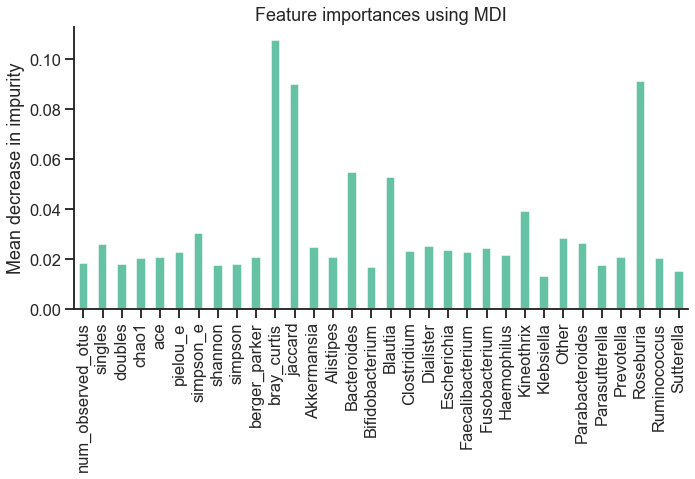

In [242]:
forest_importances = pd.Series(model.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
sns.despine()

We also take a look at our classifier's confusion matrix and ROC curve. Though our model does fairly well in classifying most patients, we could perhaps improve our model in the following ways:

- Add more genus frequency data: The addition of more genus frequency data could help better differentiate if aptient has IBD or not.
- Add more phylogenetic data: We could not do this due to computational constraints, but the introduction of phylogenetic diversity metrics such as Faith's PD and Unifrac could help improve our predictions.
- Use other ML algorithms such has XGBoost and Neural Networks.

In [ ]:
predictions = model.predict(X_test_scaled)
y_prediction = lb.fit_transform(predictions)

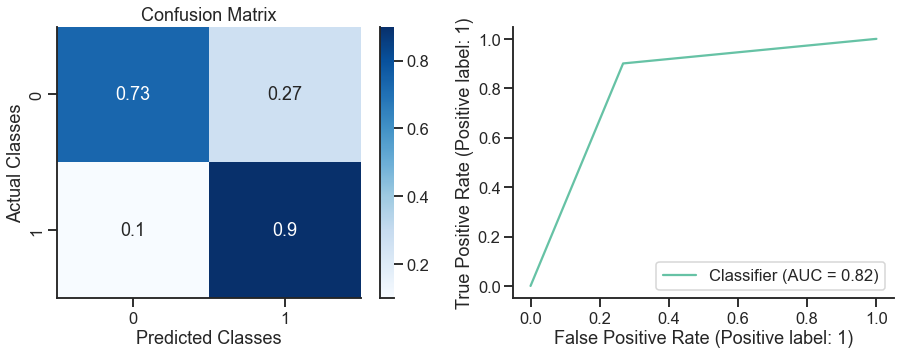

In [298]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

cm = confusion_matrix(y_test_binary.ravel(), y_prediction.ravel(), normalize='true') 
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, ax=ax[0])
ax[0].set_xlabel('Predicted Classes')
ax[0].set_ylabel('Actual Classes')
ax[0].set_title('Confusion Matrix')

metrics.RocCurveDisplay.from_predictions(y_test_binary.ravel(), y_prediction.ravel(), ax=ax[1])
sns.despine()

## References

1. https://www.crohnscolitisfoundation.org/
2. Sirami, C. 2016. Biodiversity in Heterogeneous and Dynamic Landscapes. Environmental Science.
3. Gevers et al. 2014. The treatment-naive microbiome in new-onset Crohn's disease. Cell Host Microbe 15, 382-392.
4. https://www.metagenomics.wiki/pdf/definition/16s
5. Chao, A. 1984. Non-parametric estimation of the number of classes in a population. Scandinavian Journal of Statistics 11, 265-270.
6. Chao, A. & S.-M Lee. 1992 Estimating the number of classes via sample coverage. Journal of the American Statistical Association 87, 210-217.
7. http://folk.uio.no/ohammer/past/diversity.html
8. Pielou, E. C., 1966. The measurement of diversity in different types of biological collections. Journal of Theoretical Biology, 13, 131-44.
9. http://www.pisces-conservation.com/sdrhelp/index.html
10. Berger & Parker (1970). SDR-IV online help.
11. Jaccard, P. 1912. The distribution of the flora in the alpine zone. New Phytologist 11, 27-50.
12. Bray, J. R. and J. T. Curtis. 1957. An ordination of upland forest communities of southern Wisconsin. Ecological Monographs 27:325-349